# Configuration de l'environnement

In [3]:
%pip install openmeteo-requests
%pip install requests-cache retry-requests
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install matplotlib
%pip install seaborn
%pip install pandas
%pip install statsmodels
%pip install scikit-learn
%pip install pmdarima
%pip install numpy==1.23.5

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install numpy==1.23.5

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
print(np.__version__)

1.23.5


In [8]:
# Import des bibliothèques nécessaires
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pmdarima as pm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy

# Configuration de l'affichage
sns.set_theme()

# Load data

In [ ]:
# Paramètres de requête API
start_date = "2021-01-01"
end_date = "2025-04-01"  
weather_variable = "temperature_2m"  
latitude = 48.8566  # Latitude de Paris
longitude = 2.3522  # Longitude de Paris

# URL de l'API Open-Meteo
api_url = "https://archive-api.open-meteo.com/v1/archive"

# Ajout de variables exogenes
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "surface_pressure"],
    "timezone": "auto"  # Détection automatique du fuseau horaire
}


response = requests.get(api_url, params=params)


if response.status_code == 200:
    data = response.json()
    
    df = pd.DataFrame({
        "timestamp": data["hourly"]["time"],
        "temperature_2m": data["hourly"]["temperature_2m"],
        "relative_humidity": data["hourly"]["relative_humidity_2m"],
        "precipitation": data["hourly"]["precipitation"],
        "surface_pressure": data["hourly"]["surface_pressure"]
    })
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    # Vérification des valeurs manquantes
    if df.isnull().values.any():
        print(f"Nombre de valeurs manquantes par colonne:\n{df.isnull().sum()}")
    
    if df.isnull().values.any():
        # Application de interpolation linéaire s'il y a des valeurs manquantes
        for col in df.columns:
            if col != "timestamp" and df[col].isnull().any():
                print(f"Application de l'interpolation pour la colonne {col}")
                df[col] = df[col].interpolate(method="linear")
else:
    print(f"Erreur lors de la récupération des données : {response.status_code}")

# Affichage des premières lignes du DataFrame
print("Aperçu des données récupérées:")
display(df.head())

# Informations sur le dataset
print("\nInformations sur le dataset:")
display(df.describe())

# Afficher la période couverte par les données
print(f"\nPériode couverte: du {df['timestamp'].min()} au {df['timestamp'].max()}")
print(f"Nombre total d'observations: {len(df)}")

Aperçu des données récupérées:


,timestamp,temperature_2m,relative_humidity,precipitation,surface_pressure
0,2021-01-01 00:00:00,-0.6,96,0.0,1003.4
1,2021-01-01 01:00:00,-1.3,97,0.0,1003.7
2,2021-01-01 02:00:00,-0.0,97,0.0,1003.6
3,2021-01-01 03:00:00,-0.8,97,0.0,1003.8
4,2021-01-01 04:00:00,-1.4,97,0.0,1004.2



Informations sur le dataset:


,timestamp,temperature_2m,relative_humidity,precipitation,surface_pressure
count,37248,37248.000000,37248.000000,37248.000000,37248.000000
mean,2023-02-15 23:30:00,12.239774,77.201326,0.101509,1012.698293
min,2021-01-01 00:00:00,-5.700000,17.000000,0.000000,966.600000
25%,2022-01-23 23:45:00,7.300000,67.000000,0.000000,1007.400000
50%,2023-02-15 23:30:00,11.800000,81.000000,0.000000,1013.200000
75%,2024-03-09 23:15:00,17.200000,90.000000,0.000000,1019.000000
max,2025-04-01 23:00:00,39.200000,100.000000,15.400000,1039.500000
std,NaN,7.012671,15.942724,0.445884,9.546970



Période couverte: du 2021-01-01 00:00:00 au 2025-04-01 23:00:00
Nombre total d'observations: 37248


In [10]:
df['hour'] = df['timestamp'].dt.hour

# Aggregation des données par pas de 3 heures
df['hour_group'] = (df['hour'] // 3) * 3
df['date'] = df['timestamp'].dt.date

# Regroupement par date et groupe d'heures, et calcul de la moyenne des variables
df_3h = df.groupby(['date', 'hour_group']).agg({
    'temperature_2m': 'mean',
    'relative_humidity': 'mean',
    'precipitation': 'mean',
    'surface_pressure': 'mean'
}).reset_index()

df_3h['timestamp'] = pd.to_datetime(df_3h['date'].astype(str) + ' ' + df_3h['hour_group'].astype(str) + ':00:00')

# Clean dataset
df_3h = df_3h[['timestamp', 'temperature_2m', 'relative_humidity', 'precipitation', 'surface_pressure']]
df_3h.set_index('timestamp', inplace=True)


print("Données agrégées avec un pas de temps de 3 heures:")
display(df_3h.head())

Données agrégées avec un pas de temps de 3 heures:


,temperature_2m,relative_humidity,precipitation,surface_pressure
timestamp,,,,
2021-01-01 00:00:00,-0.633333,96.666667,0.0,1003.566667
2021-01-01 03:00:00,-1.200000,97.000000,0.0,1004.133333
2021-01-01 06:00:00,-1.333333,96.000000,0.0,1004.733333
2021-01-01 09:00:00,-0.300000,95.000000,0.0,1006.000000
2021-01-01 12:00:00,2.200000,88.000000,0.0,1006.966667


# Data exploration

## Decomposition de la time series

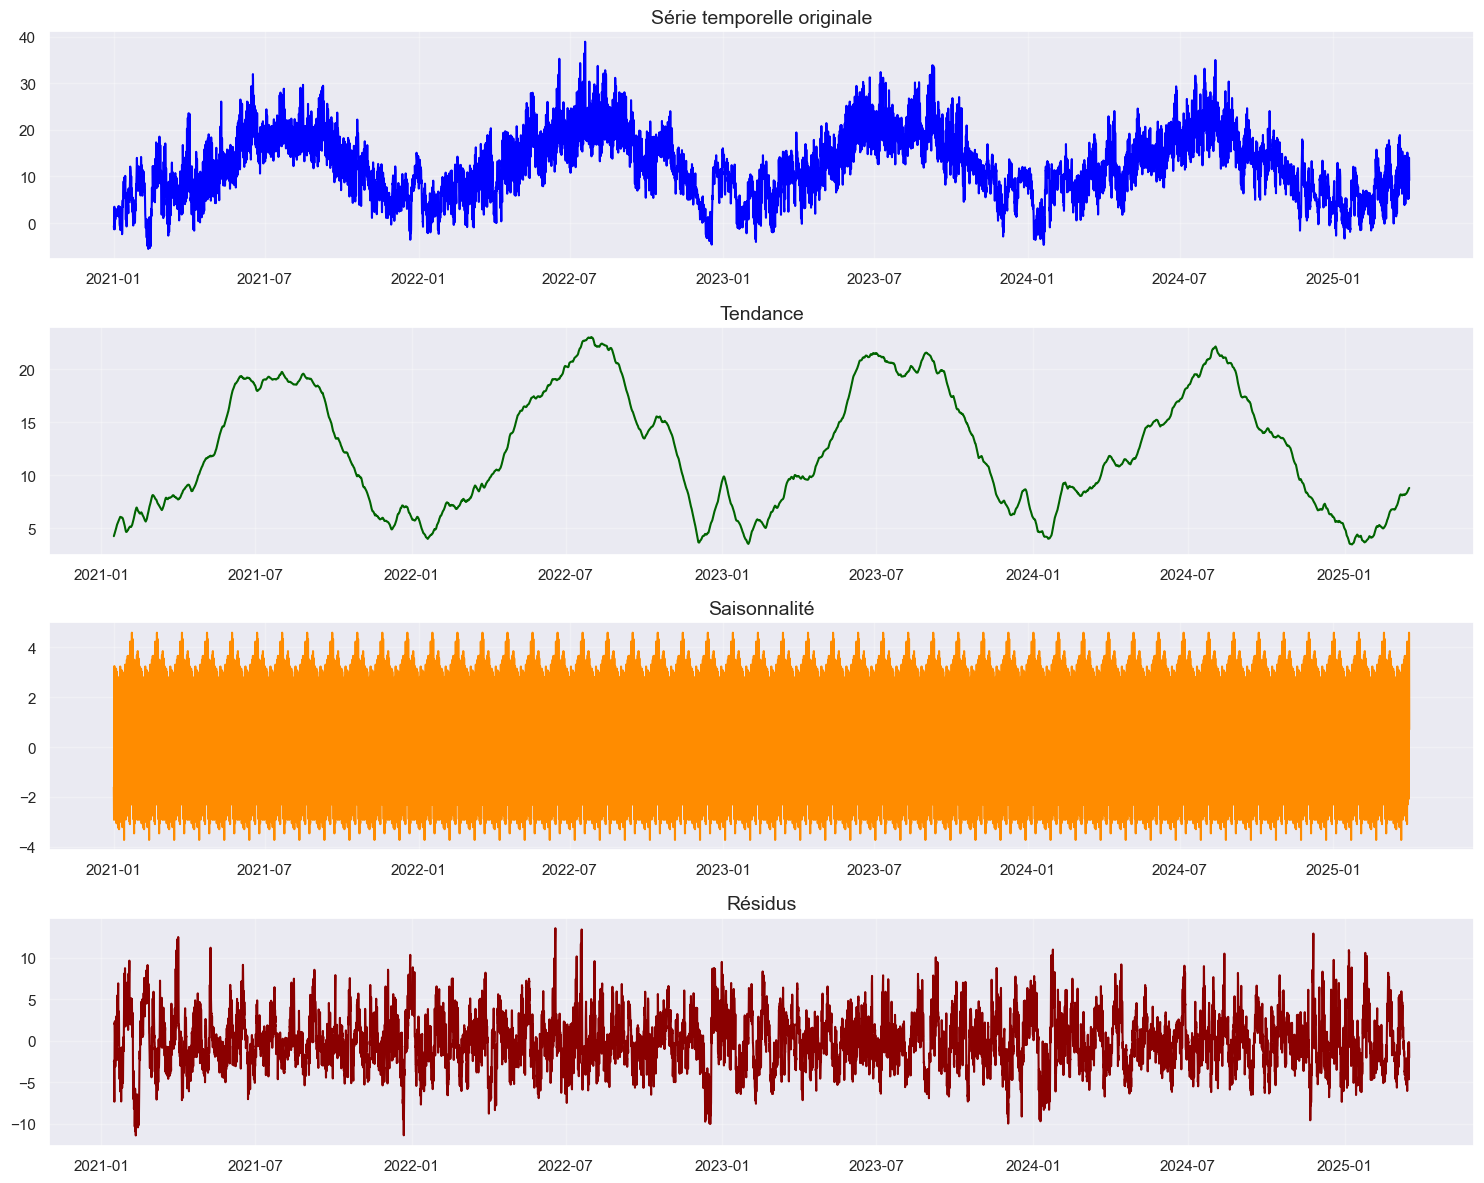

In [11]:
ts = df_3h['temperature_2m']
# Décomposition de la série temporelle (8 mesures par jour = 8*30 pour le mois)
decomposition = seasonal_decompose(ts, model='additive', period=8*30)


plt.figure(figsize=(15, 12))

plt.subplot(411)
plt.plot(ts, color='blue')
plt.title('Série temporelle originale', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(412)
plt.plot(decomposition.trend, color='darkgreen')
plt.title('Tendance', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(413)
plt.plot(decomposition.seasonal, color='darkorange')
plt.title('Saisonnalité', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(414)
plt.plot(decomposition.resid, color='darkred')
plt.title('Résidus', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualisation des données exogenes

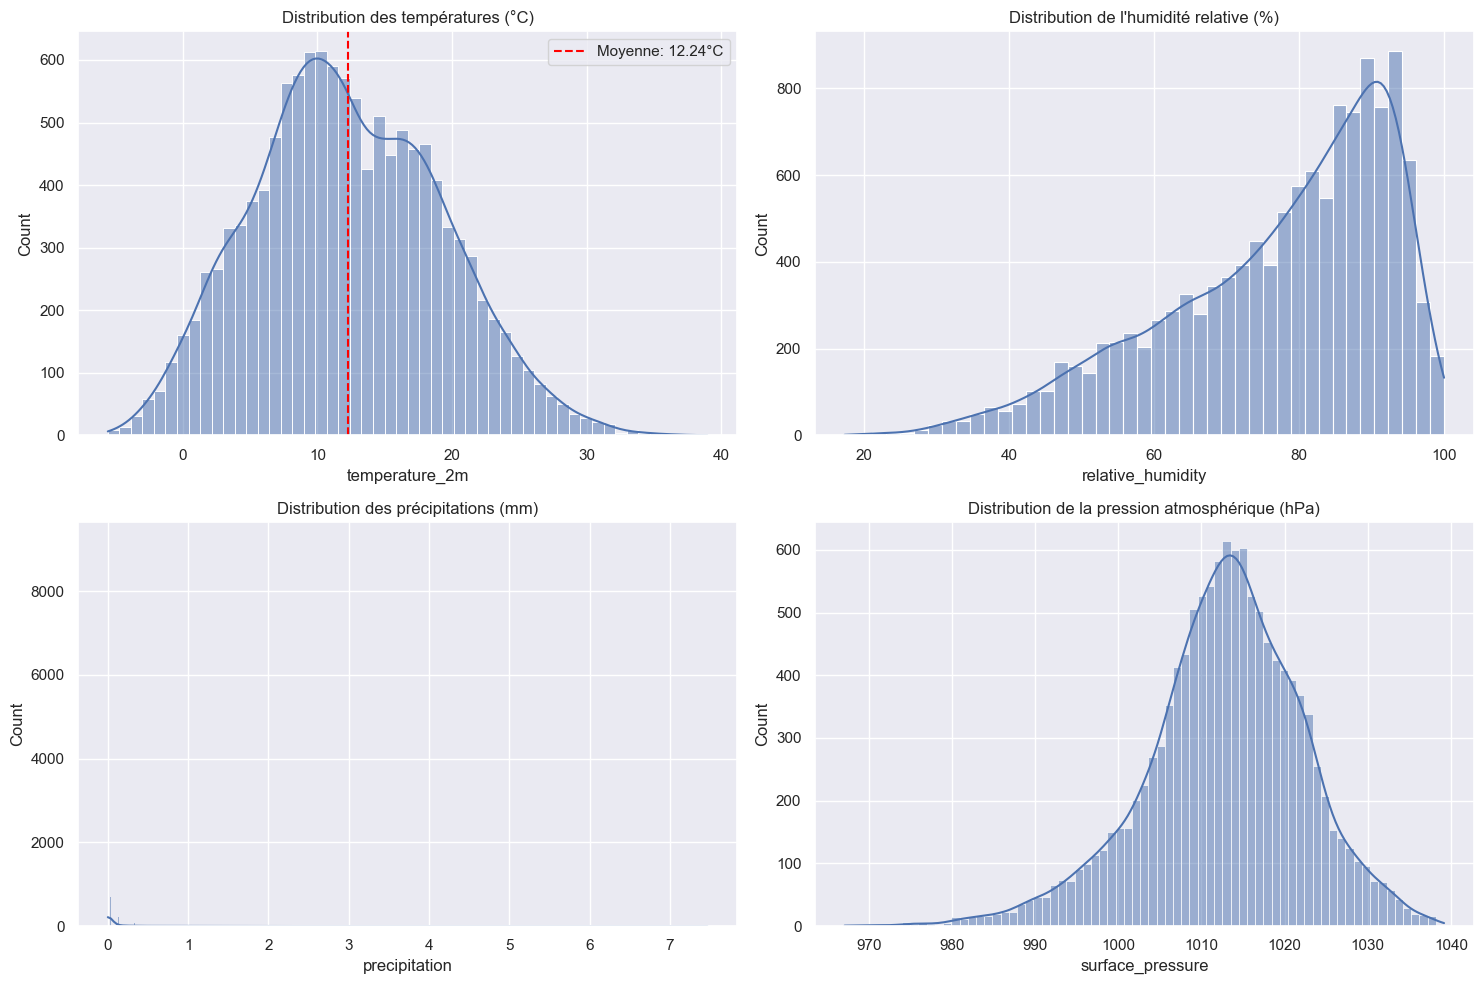

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution des températures
sns.histplot(df_3h['temperature_2m'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution des températures (°C)')
axes[0, 0].axvline(df_3h['temperature_2m'].mean(), color='red', linestyle='--', label=f'Moyenne: {df_3h["temperature_2m"].mean():.2f}°C')
axes[0, 0].legend()

# Distribution de l'humidité relative
sns.histplot(df_3h['relative_humidity'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution de l\'humidité relative (%)')

# Distribution des précipitations
sns.histplot(df_3h['precipitation'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution des précipitations (mm)')

# Distribution de la pression atmosphérique
sns.histplot(df_3h['surface_pressure'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution de la pression atmosphérique (hPa)')

plt.tight_layout()
plt.show()

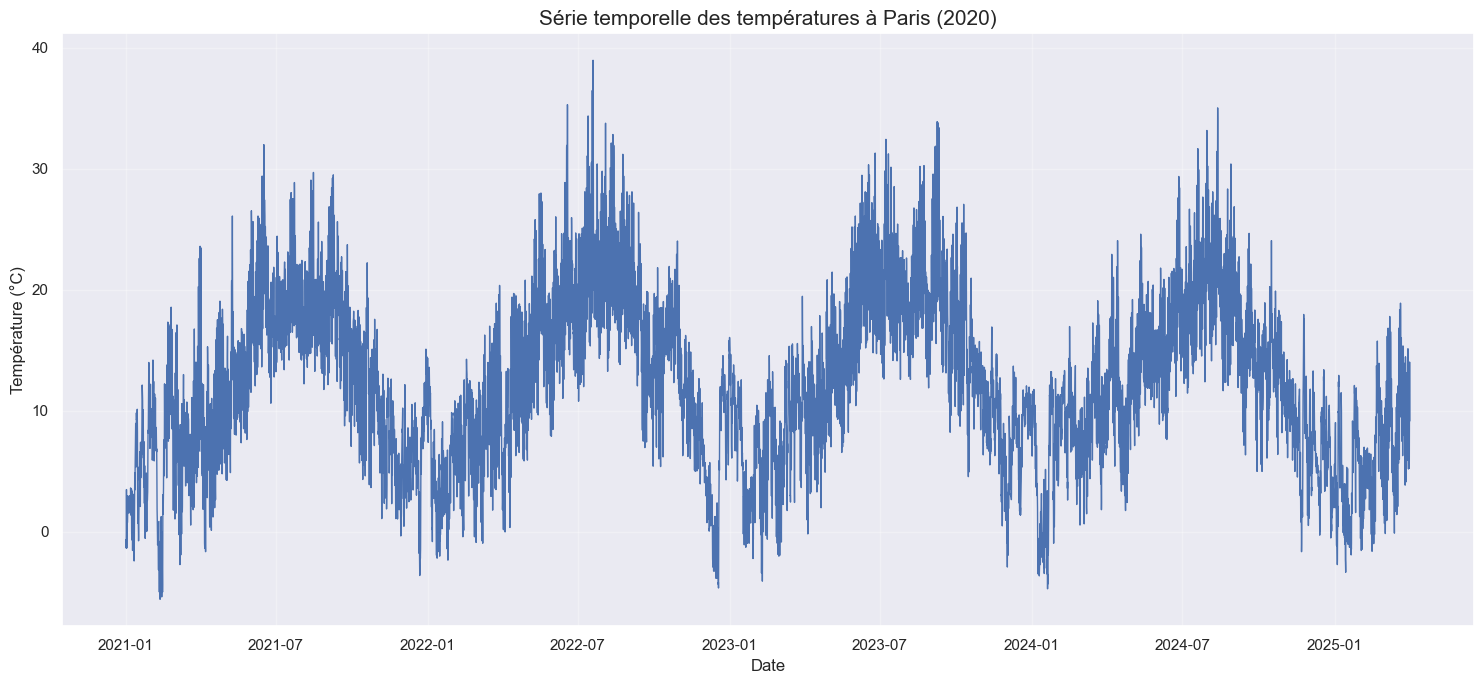

In [13]:
# 3.1 Visualisation de la série temporelle de température
plt.figure(figsize=(15, 7))
plt.plot(df_3h.index, df_3h['temperature_2m'], linewidth=1)
plt.title('Série temporelle des températures à Paris (2020)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Température (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

* La série présente une tendance ascendante avec une phase de décroissance intermédiaire et une saisonnalité forte
* La décomposition est plutot valide, car les résidus sont aléatoires et sans structure.

## Autres visualisations

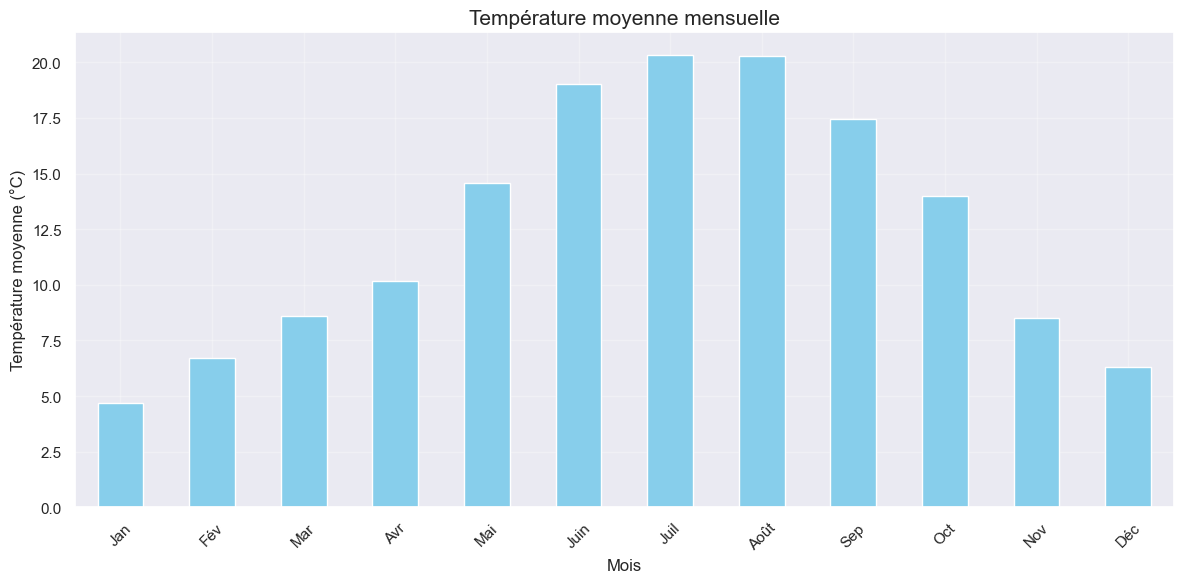

In [14]:
# Visualisation de la température par mois
df_3h_reset = df_3h.reset_index()
df_3h_reset['month'] = df_3h_reset['timestamp'].dt.month
monthly_avg = df_3h_reset.groupby('month')['temperature_2m'].mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Température moyenne mensuelle', fontsize=15)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Température moyenne (°C)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'], rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistic modeling

## Split data

Taille de l'ensemble d'entraînement: 9932
Taille de l'ensemble de test: 2484


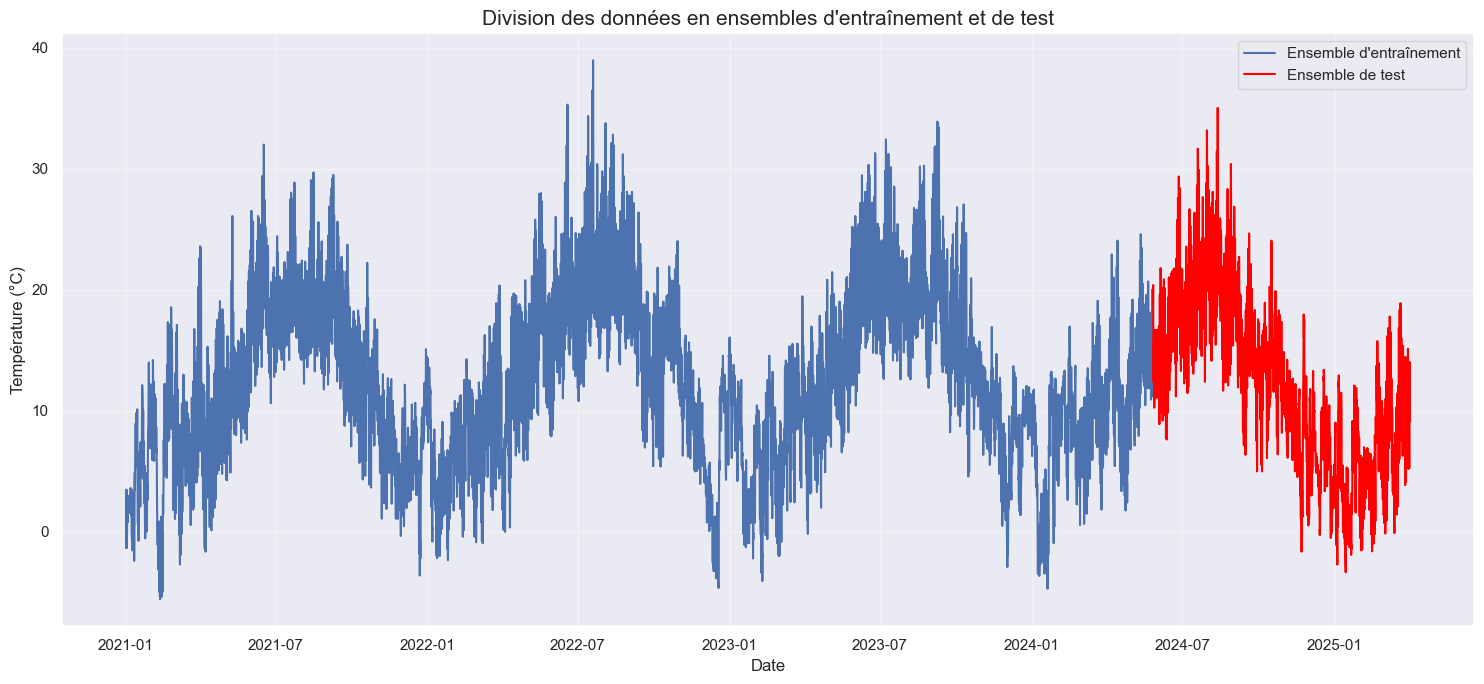

In [15]:
train_size = int(len(df_3h) * 0.8)
train_data = df_3h.iloc[:train_size]
test_data = df_3h.iloc[train_size:]

exog_train = train_data[['relative_humidity', 'precipitation', 'surface_pressure']]
exog_test = test_data[['relative_humidity', 'precipitation', 'surface_pressure']]

print(f"Taille de l'ensemble d'entraînement: {len(train_data)}")
print(f"Taille de l'ensemble de test: {len(test_data)}")


plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['temperature_2m'], label='Ensemble d\'entraînement')
plt.plot(test_data.index, test_data['temperature_2m'], label='Ensemble de test', color='red')
plt.title('Division des données en ensembles d\'entraînement et de test', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Température (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
def evaluate_model(y_true, y_pred, model_name=None):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    if model_name:
        print(f"Performances du modèle {model_name}:")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²: {r2:.4f}")
        print("-" * 40)
    
    return mae, rmse, r2

In [17]:
from statsmodels.tsa import stattools
import warnings

warnings.filterwarnings('ignore')

P_VALUE_SIGNIFICANT = 0.05

# Augmented Dickey-Fuller test
def check_adf_stat(ts):

    adf_results = stattools.adfuller(ts)
    adf_stat = adf_results[0]
    p_value = adf_results[1]
    critical_values = adf_results[4]

    print(f'The Augmented Dickey-Fuller test results\
        \n  test statistic {adf_stat:.3f},\
        \n  p-value: {p_value:.3f}\
        \n  critical values: {critical_values}')

    if (p_value < P_VALUE_SIGNIFICANT) and (adf_stat < critical_values['5%']) and\
        (adf_stat < critical_values['1%']) and (adf_stat < critical_values['10%']):
        # there is no unit roots
        print('The time series is stationary')
    else:
        # there is a unit root
        print('The time series is NOT stationary')

warnings.filterwarnings('ignore')
check_adf_stat(df_3h['temperature_2m'])

The Augmented Dickey-Fuller test results        
  test statistic -4.874,        
  p-value: 0.000        
  critical values: {'1%': -3.4308785806588684, '5%': -2.861773606144381, '10%': -2.566894343543579}
The time series is stationary


In [18]:
# Kwiatkowski–Phillips–Schmidt–Shin test
def check_kpss_stat(ts):

    kpss_results = stattools.kpss(ts)
    kpss_stat = kpss_results[0]
    p_value = kpss_results[1]
    critical_values = kpss_results[3]

    print(f'The KPSS test results\
            \n  test statistic {kpss_stat:.3f},\
            \n  p-value: {p_value:.3f}\
            \n  critical values: {critical_values}')

    if (p_value < P_VALUE_SIGNIFICANT) and (kpss_stat > critical_values['5%']) and\
        (kpss_stat > critical_values['1%']) and (kpss_stat > critical_values['10%']):
        print('The time series is NOT stationary')
    else:
        print('The time series is stationary')

warnings.filterwarnings('ignore')
check_kpss_stat(df_3h['temperature_2m'])

The KPSS test results            
  test statistic 0.394,            
  p-value: 0.080            
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is stationary


## ARIMA

In [19]:
import warnings

warnings.filterwarnings("ignore")

# Recherche des paramètres optimaux pour ARIMA
print("Recherche des paramètres optimaux pour ARIMA...")
auto_arima = pm.auto_arima(
    train_data['temperature_2m'],
    seasonal=False,
    start_p=0, start_q=0,
    max_p=10, max_q=10,
    d=None, max_d=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Affichage des meilleurs paramètres
print(f"Meilleurs paramètres ARIMA: {auto_arima.order}")

# Entraînement du modèle ARIMA avec les meilleurs paramètres
arima_order = auto_arima.order
arima_model = ARIMA(train_data['temperature_2m'], order=arima_order)
arima_result = arima_model.fit()
print(arima_result.summary())

# Prédictions sur l'ensemble de test avec ARIMA
arima_forecast = arima_result.forecast(steps=len(test_data))
arima_mae, arima_rmse, arima_r2 = evaluate_model(test_data['temperature_2m'], arima_forecast, "ARIMA")


Recherche des paramètres optimaux pour ARIMA...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44375.162, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41384.125, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39663.200, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44373.168, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39513.587, Time=0.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35687.296, Time=1.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38406.211, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=35585.501, Time=2.69 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=37741.541, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=34279.562, Time=3.20 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=35345.756, Time=0.76 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=34028.785, Time=3.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=34422.230, Time=0.84 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : 

## SARIMA

In [20]:

print("Recherche des paramètres optimaux pour SARIMA...")
auto_sarima = pm.auto_arima(
    train_data['temperature_2m'],
    seasonal=True,
    start_p=0, start_q=0,
    max_p=10, max_q=10,
    d=None, max_d=2,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=None, max_D=1,
    m=8,  # période saisonnière (8 mesures par jour)
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(f"Meilleurs paramètres SARIMA: {auto_sarima.order}x{auto_sarima.seasonal_order}")


sarima_order = auto_sarima.order
sarima_seasonal_order = auto_sarima.seasonal_order
sarima_model = SARIMAX(train_data['temperature_2m'], 
                      order=sarima_order, 
                      seasonal_order=sarima_seasonal_order)
sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())


sarima_forecast = sarima_result.forecast(steps=len(test_data))
sarima_mae, sarima_rmse, sarima_r2 = evaluate_model(test_data['temperature_2m'], sarima_forecast, "SARIMA")


Recherche des paramètres optimaux pour SARIMA...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[8] intercept   : AIC=44375.162, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[8] intercept   : AIC=32635.964, Time=1.72 sec
 ARIMA(0,1,1)(0,0,1)[8] intercept   : AIC=36162.042, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[8]             : AIC=44373.168, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[8] intercept   : AIC=41384.125, Time=0.24 sec
 ARIMA(1,1,0)(2,0,0)[8] intercept   : AIC=31161.430, Time=3.38 sec
 ARIMA(1,1,0)(2,0,1)[8] intercept   : AIC=29241.345, Time=10.33 sec
 ARIMA(1,1,0)(1,0,1)[8] intercept   : AIC=29401.308, Time=4.22 sec
 ARIMA(1,1,0)(2,0,2)[8] intercept   : AIC=29230.139, Time=14.40 sec
 ARIMA(1,1,0)(1,0,2)[8] intercept   : AIC=29257.293, Time=8.60 sec
 ARIMA(0,1,0)(2,0,2)[8] intercept   : AIC=30116.068, Time=13.49 sec
 ARIMA(2,1,0)(2,0,2)[8] intercept   : AIC=28693.692, Time=20.50 sec
 ARIMA(2,1,0)(1,0,2)[8] intercept   : AIC=28709.304, Time=10.94 sec
 ARIMA(2,1,0)(2,0,1)[8] intercep

## SARIMAX

In [21]:
# 5.5 SARIMAX avec variables exogènes
sarimax_model = SARIMAX(
    train_data['temperature_2m'], 
    exog=exog_train,
    order=sarima_order,
    seasonal_order=sarima_seasonal_order
)
sarimax_result = sarimax_model.fit(disp=False)

print(sarimax_result.summary())


sarimax_forecast = sarimax_result.forecast(steps=len(test_data), exog=exog_test)
sarimax_mae, sarimax_rmse, sarimax_r2 = evaluate_model(test_data['temperature_2m'], sarimax_forecast, "SARIMAX")

                                      SARIMAX Results                                      
Dep. Variable:                      temperature_2m   No. Observations:                 9932
Model:             SARIMAX(7, 1, 2)x(1, 0, [1], 8)   Log Likelihood              -11643.471
Date:                             Fri, 04 Apr 2025   AIC                          23316.941
Time:                                     00:17:44   BIC                          23424.992
Sample:                                 01-01-2021   HQIC                         23353.528
                                      - 05-26-2024                                         
Covariance Type:                               opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
relative_humidity    -0.1119      0.001    -89.105      0.000      -0.114      -0.109
precip

## Evaluate

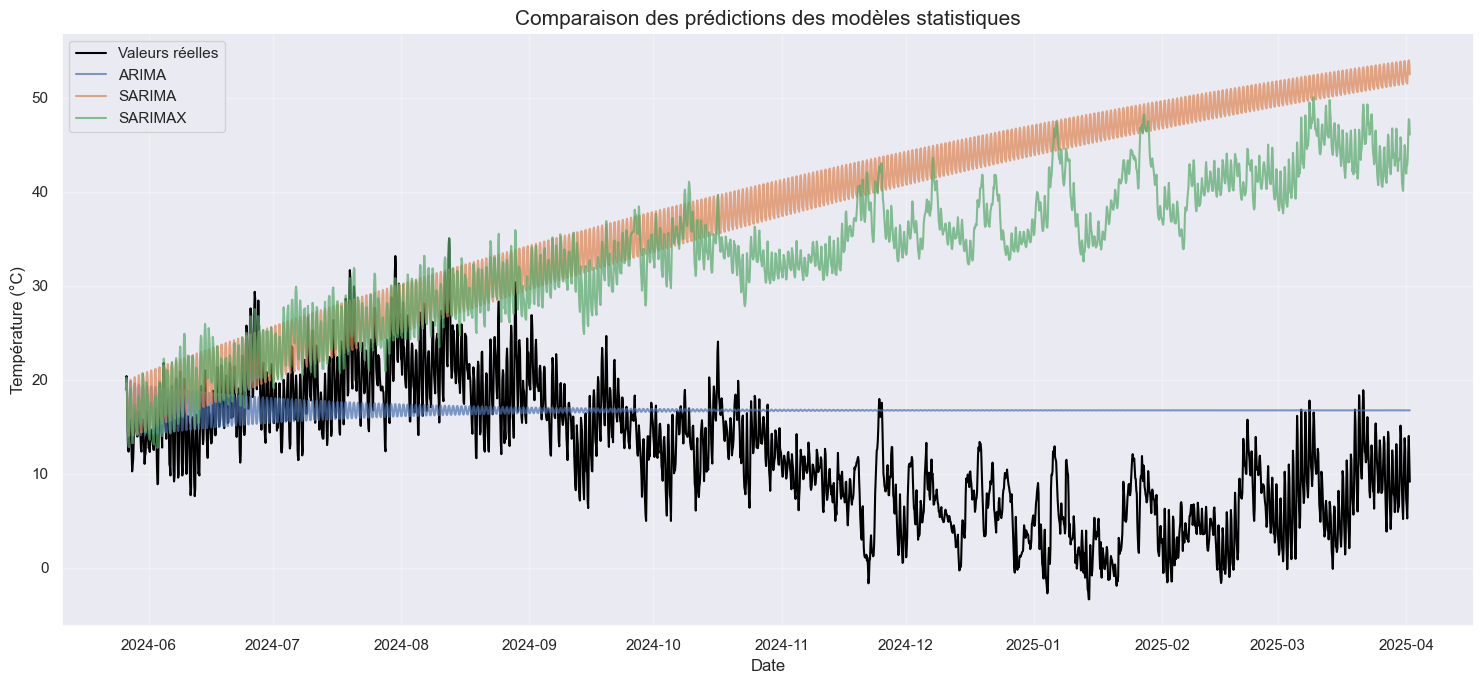

Comparaison des performances des modèles statistiques:


,Modèle,MAE,RMSE,R²
0,ARIMA,6.780467,8.338000,-0.442304
1,SARIMA,25.521949,30.014085,-17.688871
2,SARIMAX,21.316346,24.794499,-11.753915


In [ ]:
# 5.6 Visualisation des prédictions des modèles statistiques
plt.figure(figsize=(15, 7))
plt.plot(test_data.index, test_data['temperature_2m'], label='Valeurs réelles', color='black')
plt.plot(test_data.index, arima_forecast, label='ARIMA', alpha=0.7)
plt.plot(test_data.index, sarima_forecast, label='SARIMA', alpha=0.7)
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX', alpha=0.7)
plt.title('Comparaison des prédictions des modèles statistiques', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Température (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5.7 Comparaison des performances des modèles statistiques
models_stat = ['ARIMA', 'SARIMA', 'SARIMAX']
mae_values = [arima_mae, sarima_mae, sarimax_mae]
rmse_values = [arima_rmse, sarima_rmse, sarimax_rmse]
r2_values = [arima_r2, sarima_r2, sarimax_r2]

stat_results_df = pd.DataFrame({
    'Modèle': models_stat,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R²': r2_values
})

print("Comparaison des performances des modèles statistiques:")
display(stat_results_df)

# ML Experimentations

## Prepare data

In [ ]:
def create_features(df):
    df_features = df.copy()
    
    # Création des variables retardées (lag variables)
    for i in range(1, 20):
        df_features[f'temp_lag_{i}'] = df_features['temperature_2m'].shift(i)
    
    # Variables temporelles
    df_features['hour'] = df_features.index.hour
    df_features['dayofweek'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month
    df_features['day'] = df_features.index.day
    
    # moyenne mobile
    df_features['temp_rolling_mean_24h'] = df_features['temperature_2m'].rolling(window=8).mean()  # Moyenne mobile sur 24h (8 périodes de 3h)
    df_features['temp_rolling_std_24h'] = df_features['temperature_2m'].rolling(window=8).std()  # Écart-type mobile sur 24h
    
    df_features = df_features.dropna()
    
    return df_features


train_features = create_features(train_data)
test_features = create_features(test_data)

# Split
X_train = train_features.drop('temperature_2m', axis=1)
y_train = train_features['temperature_2m']
X_test = test_features.drop('temperature_2m', axis=1)
y_test = test_features['temperature_2m']

print(f"Forme de X_train: {X_train.shape}")
print(f"Forme de X_test: {X_test.shape}")
print(f"Variables explicatives: {X_train.columns.tolist()}")

Forme de X_train: (9913, 28)
Forme de X_test: (2465, 28)
Variables explicatives: ['relative_humidity', 'precipitation', 'surface_pressure', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_4', 'temp_lag_5', 'temp_lag_6', 'temp_lag_7', 'temp_lag_8', 'temp_lag_9', 'temp_lag_10', 'temp_lag_11', 'temp_lag_12', 'temp_lag_13', 'temp_lag_14', 'temp_lag_15', 'temp_lag_16', 'temp_lag_17', 'temp_lag_18', 'temp_lag_19', 'hour', 'dayofweek', 'month', 'day', 'temp_rolling_mean_24h', 'temp_rolling_std_24h']


## Modeling

In [ ]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 6.3 Entraînement et évaluation des modèles
ml_results = {}

for name, model in models.items():
    print(f"Entraînement du modèle: {name}")
    
    pipeline = Pipeline([
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae, rmse, r2 = evaluate_model(y_test, y_pred, name)
    ml_results[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

Entraînement du modèle: Random Forest
Performances du modèle Random Forest:
MAE: 0.8121
RMSE: 1.0804
R²: 0.9759
----------------------------------------
Entraînement du modèle: Gradient Boosting
Performances du modèle Gradient Boosting:
MAE: 0.8902
RMSE: 1.1515
R²: 0.9726
----------------------------------------


## Evaluate

In [33]:
ml_results_df = pd.DataFrame(ml_results).T
print("Comparaison des performances des modèles de Machine Learning:")
display(ml_results_df)

Comparaison des performances des modèles de Machine Learning:


,MAE,RMSE,R²
Random Forest,0.812087,1.080411,0.975913
Gradient Boosting,0.890178,1.151472,0.972640


Le meilleur modèle de ML est: Random Forest
Optimisation des hyperparamètres pour Random Forest...
Meilleurs hyperparamètres: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Performances du modèle Random Forest (optimisé):
MAE: 0.8063
RMSE: 1.0732
R²: 0.9762
----------------------------------------


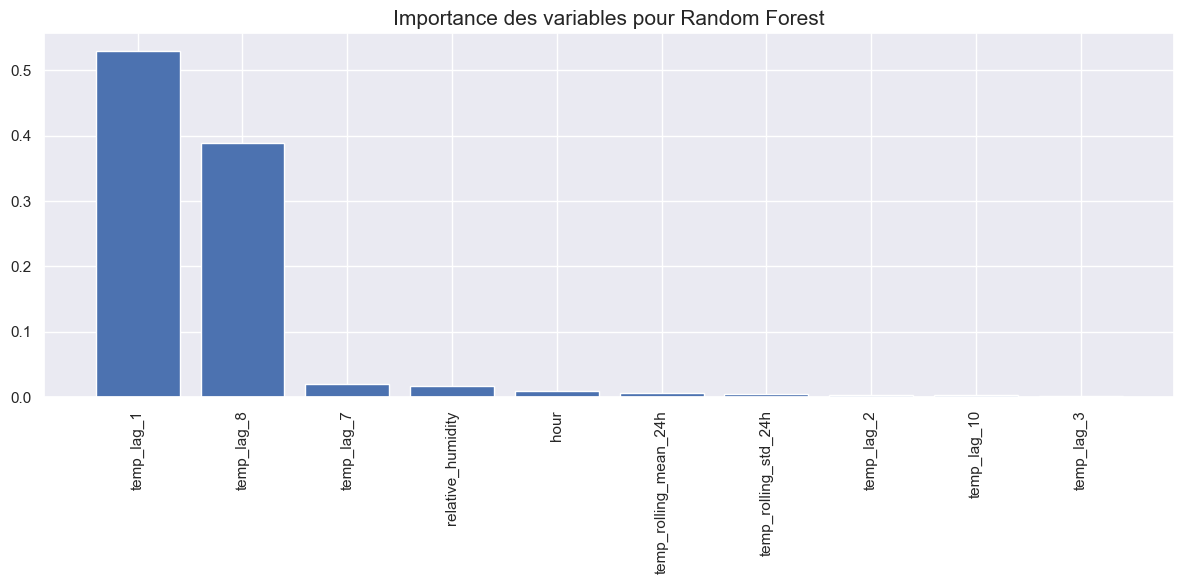

In [34]:
best_ml_model = ml_results_df['RMSE'].idxmin()
print(f"Le meilleur modèle de ML est: {best_ml_model}")


param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}
best_model = RandomForestRegressor(random_state=42)


print(f"Optimisation des hyperparamètres de {best_ml_model}...")

pipeline = Pipeline([
    ('model', best_model)
])

# Utiliser TimeSeriesSplit pour la validation croisée des séries temporelles
tscv = TimeSeriesSplit(n_splits=5)

# Recherche par grille
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
print(f"Meilleurs hyperparamètres: {grid_search.best_params_}")

y_pred_opt = grid_search.predict(X_test)
best_mae, best_rmse, best_r2 = evaluate_model(y_test, y_pred_opt, f"{best_ml_model} (optimisé)")

best_pipeline = grid_search.best_estimator_

feature_importances = best_pipeline.named_steps['model'].feature_importances_
features = X_train.columns

# Tri des features par importance
indices = np.argsort(feature_importances)[::-1]

# Affichage des 10 features les plus importantes
plt.figure(figsize=(12, 6))
plt.title(f"Importance des variables pour {best_ml_model}", fontsize=15)
plt.bar(range(10), feature_importances[indices][:10], align='center')
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=90)
plt.tight_layout()
plt.show()


# Results analysis

In [44]:
stat_results_df['Modèle']

0      ARIMA
1     SARIMA
2    SARIMAX
Name: Modèle, dtype: object

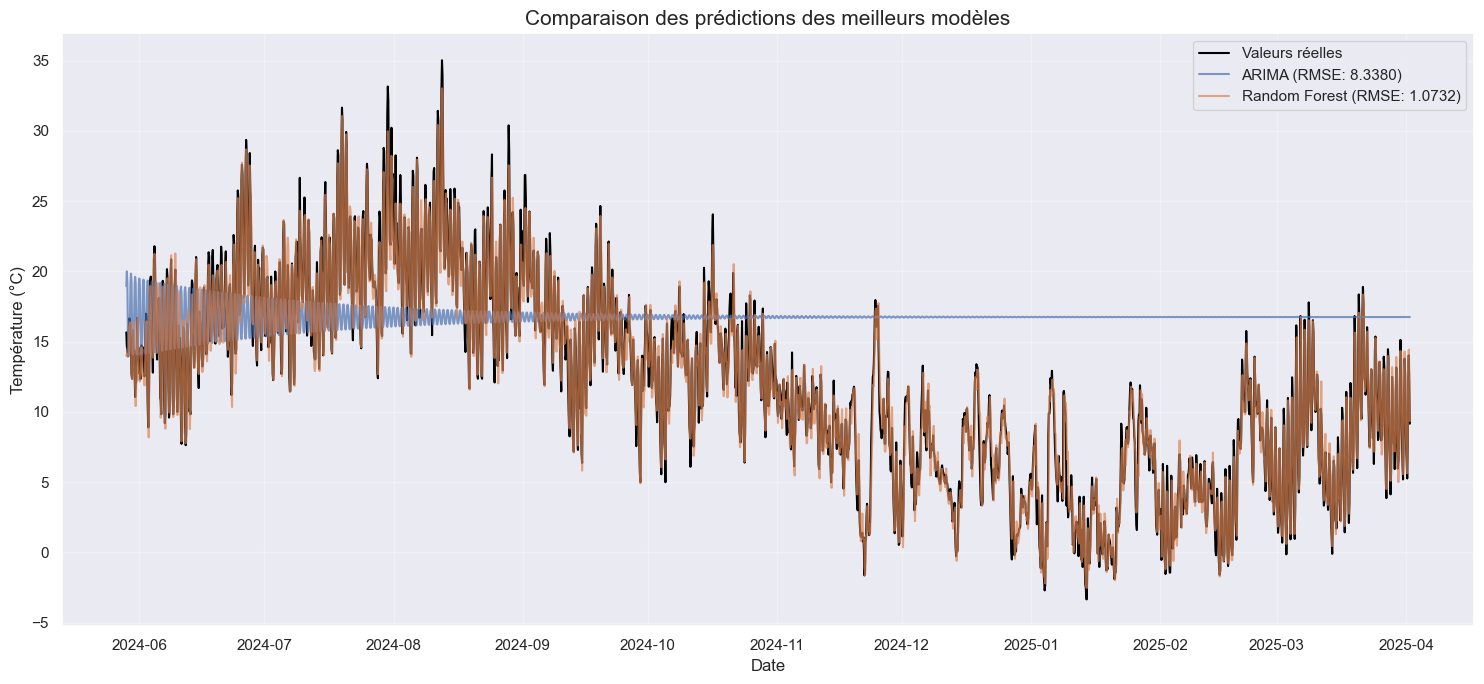

In [48]:
# Récupération des meilleures prédictions statistiques et ML
best_stat_model = 'ARIMA'
stat_pred = arima_forecast
stat_rmse = arima_rmse

ml_pred = y_pred_opt
ml_rmse = best_rmse

# Visualisation des prédictions des meilleurs modèles
plt.figure(figsize=(15, 7))
plt.plot(test_features.index, y_test, label='Valeurs réelles', color='black')
plt.plot(test_features.index, stat_pred[:len(test_features)], label=f'{best_stat_model} (RMSE: {stat_rmse:.4f})', alpha=0.7)
plt.plot(test_features.index, ml_pred, label=f'{best_ml_model} (RMSE: {ml_rmse:.4f})', alpha=0.7)
plt.title('Comparaison des prédictions des meilleurs modèles', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Température (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analyse des résidus

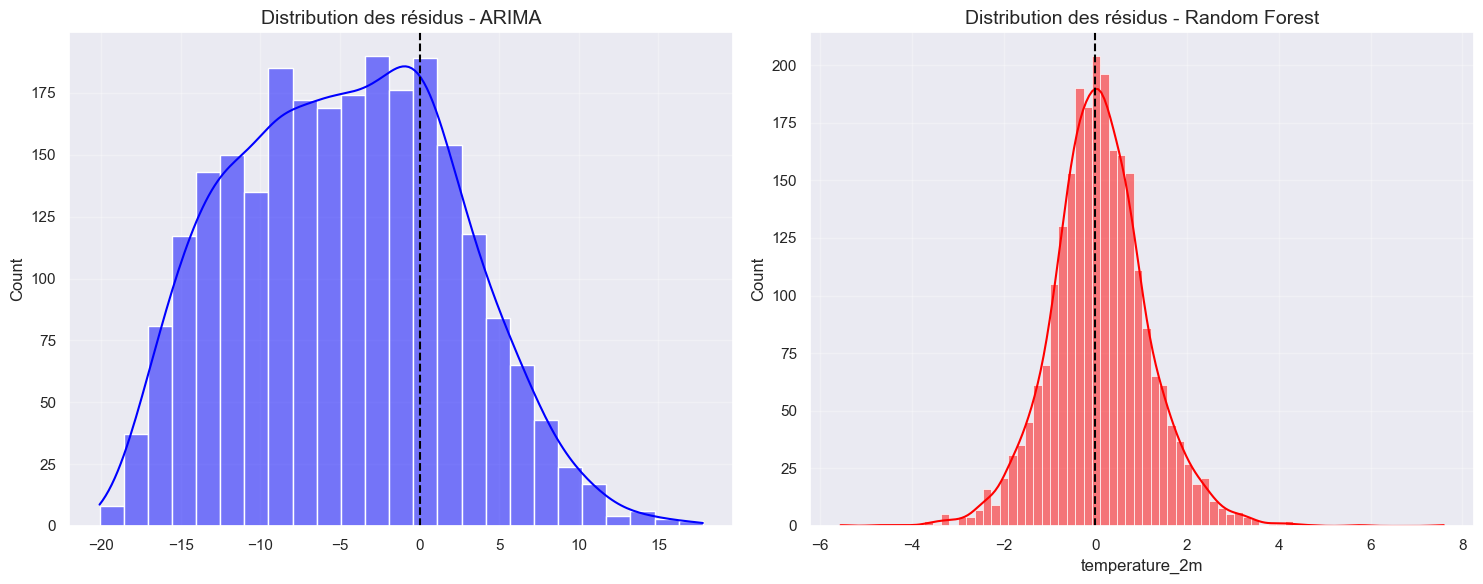

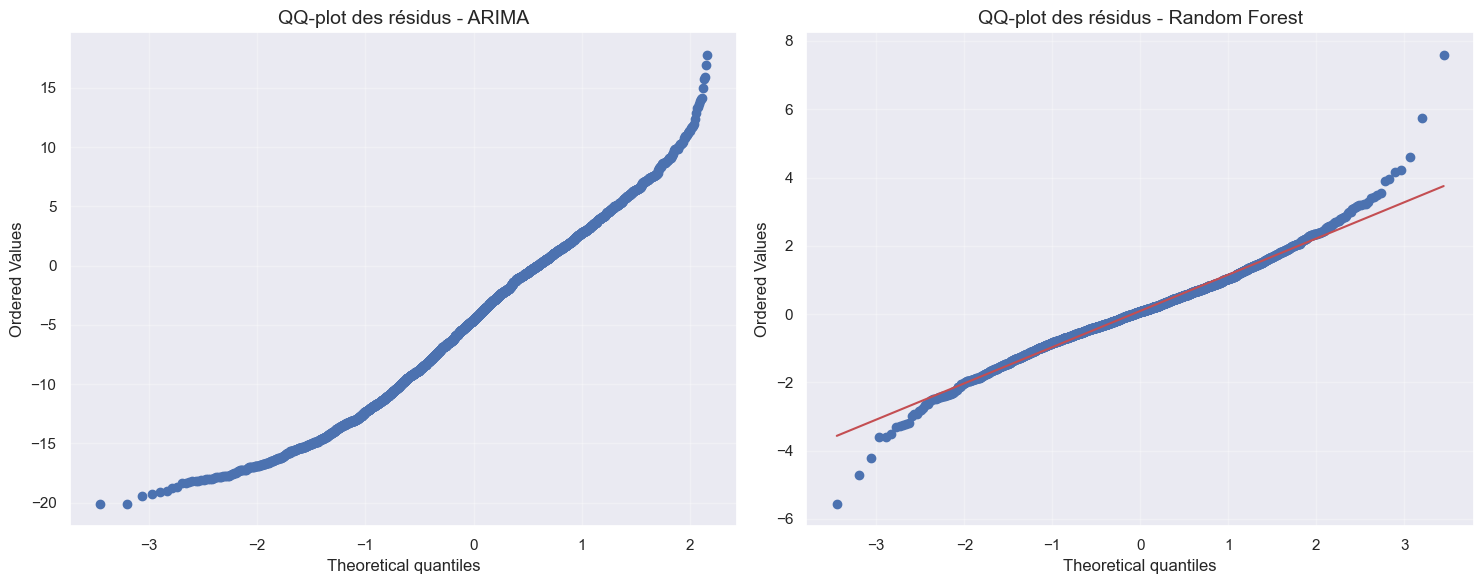

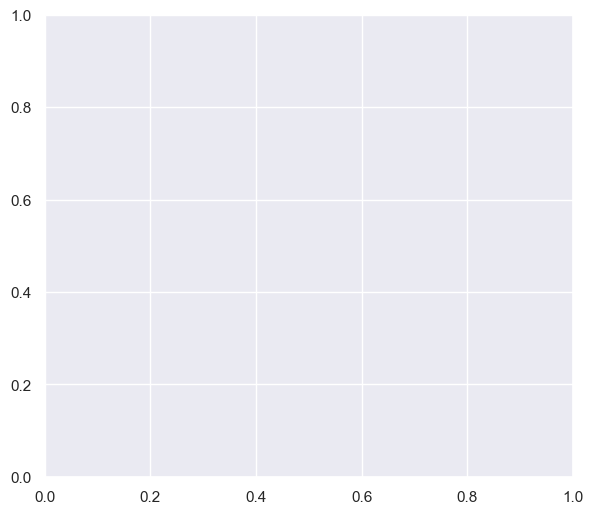

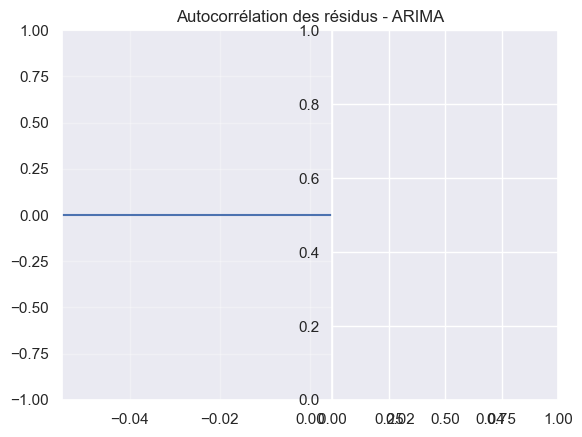

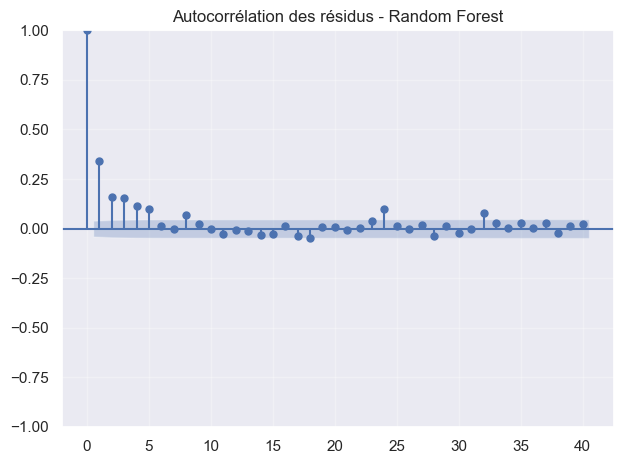

Test de Ljung-Box pour ARIMA:
    lb_stat  lb_pvalue
10      NaN        NaN
20      NaN        NaN
30      NaN        NaN

Test de Ljung-Box pour Random Forest:
       lb_stat     lb_pvalue
10  476.450275  4.733682e-96
20  492.906534  8.884686e-92
30  527.618159  2.572797e-92


In [49]:
stat_residuals = y_test - stat_pred[:len(test_features)]
ml_residuals = y_test - ml_pred

# Distribution des résidus
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.histplot(stat_residuals, kde=True, color='blue')
plt.title(f'Distribution des résidus - {best_stat_model}', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)

plt.subplot(122)
sns.histplot(ml_residuals, kde=True, color='red')
plt.title(f'Distribution des résidus - {best_ml_model}', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

from scipy import stats

# QQ-plot des résidus pour vérifier la normalité
plt.figure(figsize=(15, 6))
plt.subplot(121)
stats.probplot(stat_residuals, dist="norm", plot=plt)
plt.title(f'QQ-plot des résidus - {best_stat_model}', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(122)
stats.probplot(ml_residuals, dist="norm", plot=plt)
plt.title(f'QQ-plot des résidus - {best_ml_model}', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Autocorrélation des résidus
plt.figure(figsize=(15, 6))

plt.subplot(121)
plot_acf(stat_residuals, lags=40, alpha=0.05, title=f'Autocorrélation des résidus - {best_stat_model}')
plt.grid(True, alpha=0.3)

plt.subplot(122)
plot_acf(ml_residuals, lags=40, alpha=0.05, title=f'Autocorrélation des résidus - {best_ml_model}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_stat_test = acorr_ljungbox(stat_residuals, lags=[10, 20, 30])
lb_ml_test = acorr_ljungbox(ml_residuals, lags=[10, 20, 30])

print(f"Test de Ljung-Box pour {best_stat_model}:")
print(lb_stat_test)
print(f"\nTest de Ljung-Box pour {best_ml_model}:")
print(lb_ml_test)

## Recap

In [53]:
# Filter the row corresponding to the best_stat_model
stat_model_row = stat_results_df[stat_results_df['Modèle'] == best_stat_model].iloc[0]

final_comparison = pd.DataFrame({
    'Modèle': [best_stat_model, best_ml_model],
    'Type': ['Statistique', 'Machine Learning'],
    'MAE': [stat_model_row['MAE'], best_mae],
    'RMSE': [stat_model_row['RMSE'], best_rmse],
    'R²': [stat_model_row['R²'], best_r2]
})

print("Comparaison finale des meilleurs modèles:")
display(final_comparison)

Comparaison finale des meilleurs modèles:


,Modèle,Type,MAE,RMSE,R²
0,ARIMA,Statistique,6.780467,8.338000,-0.442304
1,Random Forest,Machine Learning,0.806283,1.073218,0.976233
